
True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ  : True Positives = 2049304, False Positives = 35888, False Negatives = 862427
  5x  BAM  : True Positives = 1543388, False Positives = 182643, False Negatives = 1368343
  10x  FASTQ  : True Positives = 2649087, False Positives = 30931, False Negatives = 262644
  10x  BAM  : True Positives = 1728232, False Positives = 71666, False Negatives = 1183499
  15x  FASTQ  : True Positives = 2806542, False Positives = 29276, False Negatives = 105189
  15x  BAM  : True Positives = 1909398, False Positives = 132775, False Negatives = 1002333
  20x  FASTQ  : True Positives = 2859142, False Positives = 14653, False Negatives = 52589
  20x  BAM  : True Positives = 2839343, False Positives = 154949, False Negatives = 72388
  36x  FASTQ  : True Positives = 2904998, False Positives = 6883, False Negatives = 6733
  36x  BAM  : True Positives = 2896937, False Positives = 454854, False Negatives = 14794
  5x  FASTQ  : True Positiv

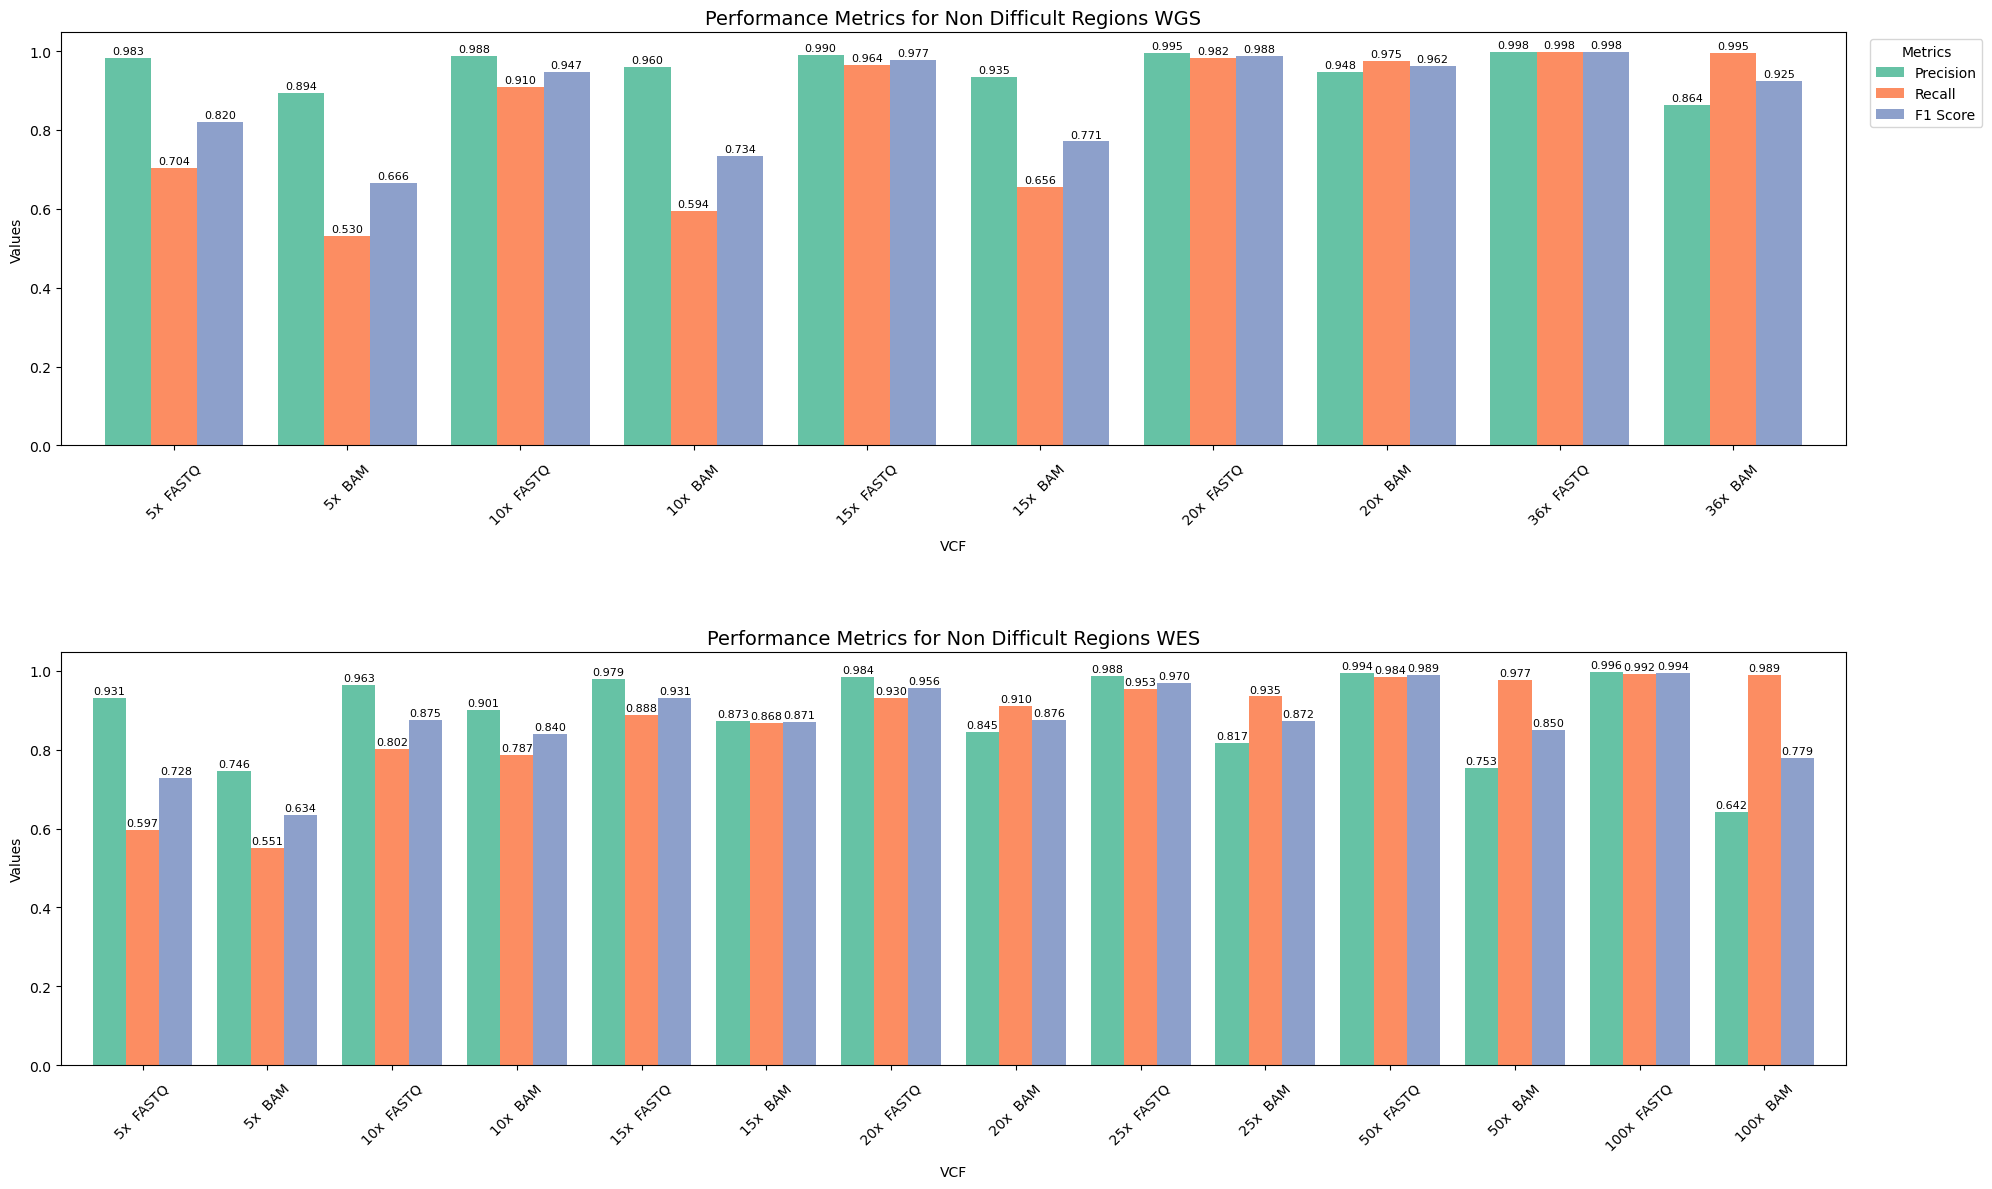

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "Non Difficult Regions"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_non_difficult_regions.vcf', 'wgs_5x_BAM_non_difficult_regions.vcf',
            'wgs_10x_FASTQ_non_difficult_regions.vcf', 'wgs_10x_BAM_non_difficult_regions.vcf',
            'wgs_15x_FASTQ_non_difficult_regions.vcf', 'wgs_15x_BAM_non_difficult_regions.vcf',
            'wgs_20x_FASTQ_non_difficult_regions.vcf', 'wgs_20x_BAM_non_difficult_regions.vcf',
            'wgs_36x_FASTQ_non_difficult_regions.vcf', 'wgs_36x_BAM_non_difficult_regions.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_non_difficult_regions.vcf', 'wes_5x_BAM_non_difficult_regions.vcf',
            'wes_10x_FASTQ_non_difficult_regions.vcf', 'wes_10x_BAM_non_difficult_regions.vcf',
            'wes_15x_FASTQ_non_difficult_regions.vcf', 'wes_15x_BAM_non_difficult_regions.vcf',
            'wes_20x_FASTQ_non_difficult_regions.vcf', 'wes_20x_BAM_non_difficult_regions.vcf',
            'wes_25x_FASTQ_non_difficult_regions.vcf', 'wes_25x_BAM_non_difficult_regions.vcf',
            'wes_50x_FASTQ_non_difficult_regions.vcf', 'wes_50x_BAM_non_difficult_regions.vcf',
            'wes_100x_FASTQ_non_difficult_regions.vcf', 'wes_100x_BAM_non_difficult_regions.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('snps', ' ') \
                   .replace('difficult regions', '').replace('non difficult regions', '').replace('non', '')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for Non Difficult Regions WGS', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for Non Difficult Regions WES', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("non_difficult_regions.png", dpi=300)
plt.show()



True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ    : True Positives = 1934410, False Positives = 23106, False Negatives = 817697
  5x  BAM    : True Positives = 1460203, False Positives = 168194, False Negatives = 1291904
  10x  FASTQ    : True Positives = 2502309, False Positives = 15296, False Negatives = 249798
  10x  BAM    : True Positives = 1634189, False Positives = 56356, False Negatives = 1117918
  15x  FASTQ    : True Positives = 2652006, False Positives = 14815, False Negatives = 100101
  15x  BAM    : True Positives = 1805206, False Positives = 91428, False Negatives = 946901
  20x  FASTQ    : True Positives = 2702080, False Positives = 9785, False Negatives = 50027
  20x  BAM    : True Positives = 2684039, False Positives = 116469, False Negatives = 68068
  36x  FASTQ    : True Positives = 2745898, False Positives = 5827, False Negatives = 6209
  36x  BAM    : True Positives = 2738464, False Positives = 360573, False Negatives = 13643
  5x  FAST

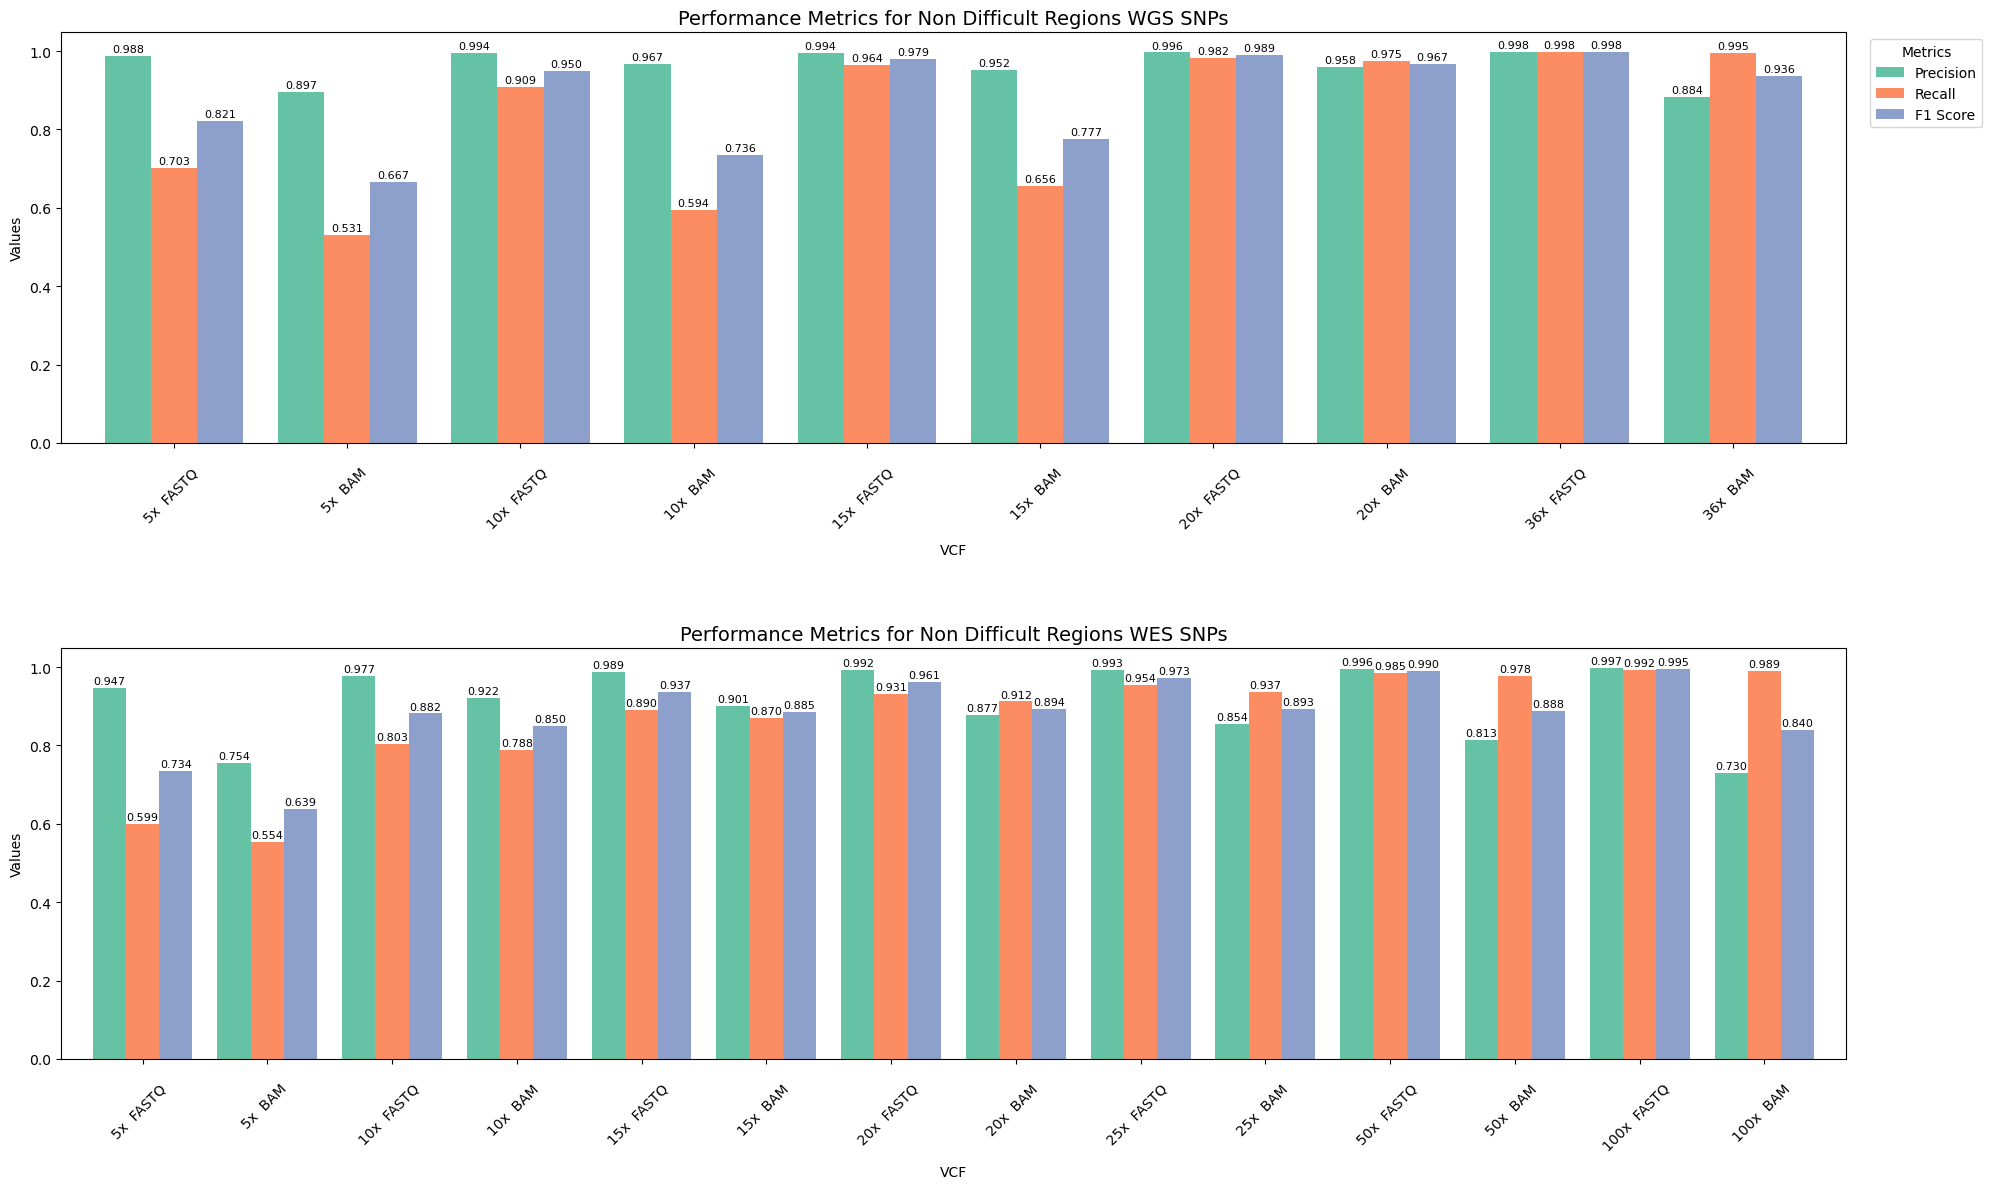

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "Non Difficult Regions/snps"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_snps.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_non_difficult_regions_snps.vcf', 'wgs_5x_BAM_non_difficult_regions_snps.vcf',
            'wgs_10x_FASTQ_non_difficult_regions_snps.vcf', 'wgs_10x_BAM_non_difficult_regions_snps.vcf',
            'wgs_15x_FASTQ_non_difficult_regions_snps.vcf', 'wgs_15x_BAM_non_difficult_regions_snps.vcf',
            'wgs_20x_FASTQ_non_difficult_regions_snps.vcf', 'wgs_20x_BAM_non_difficult_regions_snps.vcf',
            'wgs_36x_FASTQ_non_difficult_regions_snps.vcf', 'wgs_36x_BAM_non_difficult_regions_snps.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_snps.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_snps.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_non_difficult_regions_snps.vcf', 'wes_5x_BAM_non_difficult_regions_snps.vcf',
            'wes_10x_FASTQ_non_difficult_regions_snps.vcf', 'wes_10x_BAM_non_difficult_regions_snps.vcf',
            'wes_15x_FASTQ_non_difficult_regions_snps.vcf', 'wes_15x_BAM_non_difficult_regions_snps.vcf',
            'wes_20x_FASTQ_non_difficult_regions_snps.vcf', 'wes_20x_BAM_non_difficult_regions_snps.vcf',
            'wes_25x_FASTQ_non_difficult_regions_snps.vcf', 'wes_25x_BAM_non_difficult_regions_snps.vcf',
            'wes_50x_FASTQ_non_difficult_regions_snps.vcf', 'wes_50x_BAM_non_difficult_regions_snps.vcf',
            'wes_100x_FASTQ_non_difficult_regions_snps.vcf', 'wes_100x_BAM_non_difficult_regions_snps.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_snps.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('snps', ' ') \
                   .replace('difficult regions', '').replace('non difficult regions', '').replace('non', '')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for Non Difficult Regions WGS SNPs', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for Non Difficult Regions WES SNPs', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("non_difficult_regions_SNPs.png", dpi=300)
plt.show()



True Positives, False Positives, and False Negatives per VCF:

  5x  FASTQ    : True Positives = 114895, False Positives = 12791, False Negatives = 44746
  5x  BAM    : True Positives = 83186, False Positives = 14465, False Negatives = 76455
  10x  FASTQ    : True Positives = 146780, False Positives = 15646, False Negatives = 12861
  10x  BAM    : True Positives = 94044, False Positives = 15323, False Negatives = 65597
  15x  FASTQ    : True Positives = 154540, False Positives = 14477, False Negatives = 5101
  15x  BAM    : True Positives = 104194, False Positives = 41378, False Negatives = 55447
  20x  FASTQ    : True Positives = 157067, False Positives = 4883, False Negatives = 2574
  20x  BAM    : True Positives = 155309, False Positives = 38522, False Negatives = 4332
  36x  FASTQ    : True Positives = 159105, False Positives = 1069, False Negatives = 536
  36x  BAM    : True Positives = 158478, False Positives = 94376, False Negatives = 1163
  5x  FASTQ    : True Positives = 669,

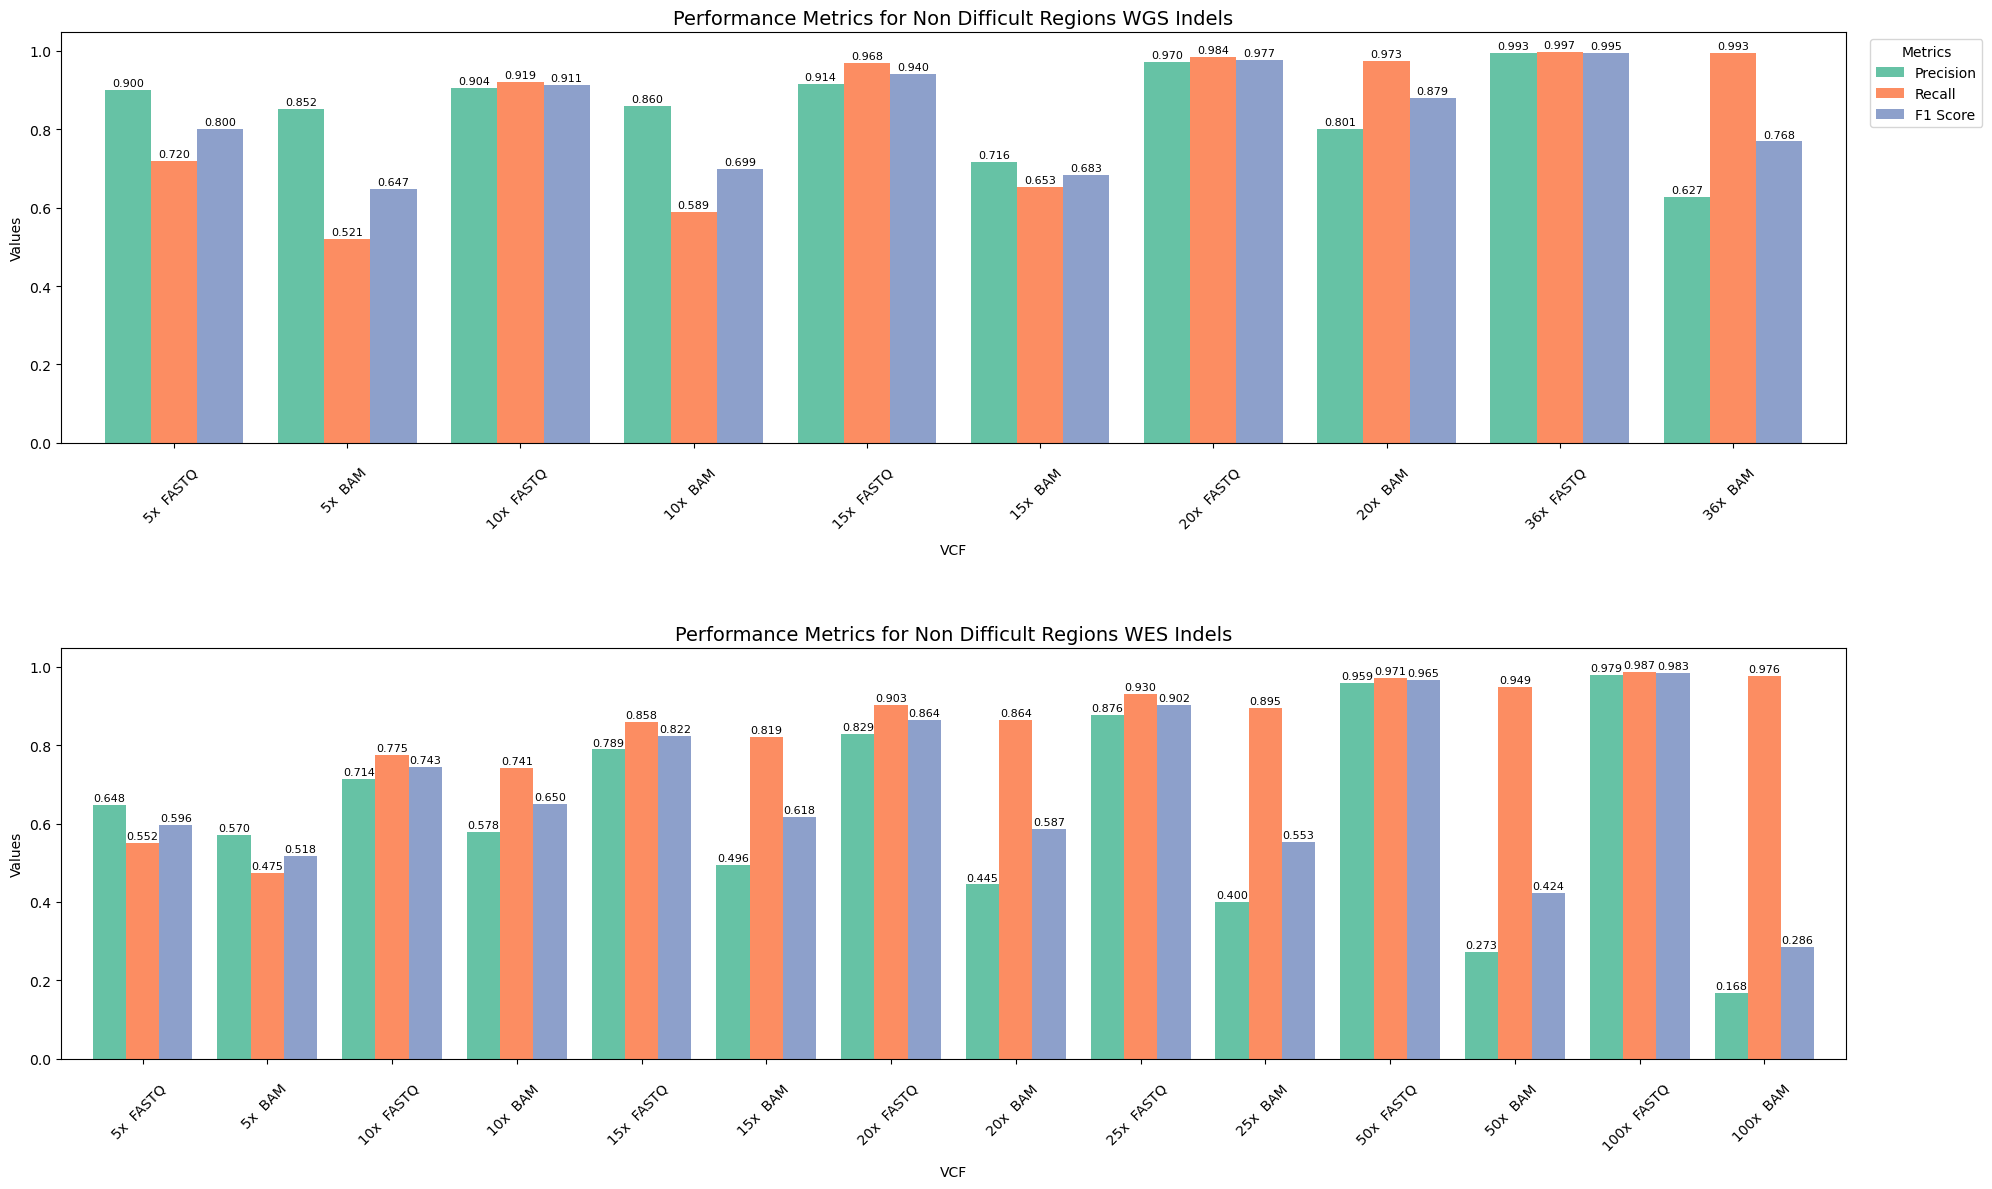

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF
import os

# Base directory for all VCF files
BASE_DIR = "Non Difficult Regions/indels"

# Store reference files and sample VCFs for wgs and wes
datasets = {
    'wgs': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_indels.vcf',
        'vcf_files': [
            'wgs_5x_FASTQ_non_difficult_regions_indels.vcf', 'wgs_5x_BAM_non_difficult_regions_indels.vcf',
            'wgs_10x_FASTQ_non_difficult_regions_indels.vcf', 'wgs_10x_BAM_non_difficult_regions_indels.vcf',
            'wgs_15x_FASTQ_non_difficult_regions_indels.vcf', 'wgs_15x_BAM_non_difficult_regions_indels.vcf',
            'wgs_20x_FASTQ_non_difficult_regions_indels.vcf', 'wgs_20x_BAM_non_difficult_regions_indels.vcf',
            'wgs_36x_FASTQ_non_difficult_regions_indels.vcf', 'wgs_36x_BAM_non_difficult_regions_indels.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_indels.vcf'  # Will be removed from plot later
        ]
    },
    'wes': {
        'reference': 'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_indels.vcf',
        'vcf_files': [
            'wes_5x_FASTQ_non_difficult_regions_indels.vcf', 'wes_5x_BAM_non_difficult_regions_indels.vcf',
            'wes_10x_FASTQ_non_difficult_regions_indels.vcf', 'wes_10x_BAM_non_difficult_regions_indels.vcf',
            'wes_15x_FASTQ_non_difficult_regions_indels.vcf', 'wes_15x_BAM_non_difficult_regions_indels.vcf',
            'wes_20x_FASTQ_non_difficult_regions_indels.vcf', 'wes_20x_BAM_non_difficult_regions_indels.vcf',
            'wes_25x_FASTQ_non_difficult_regions_indels.vcf', 'wes_25x_BAM_non_difficult_regions_indels.vcf',
            'wes_50x_FASTQ_non_difficult_regions_indels.vcf', 'wes_50x_BAM_non_difficult_regions_indels.vcf',
            'wes_100x_FASTQ_non_difficult_regions_indels.vcf', 'wes_100x_BAM_non_difficult_regions_indels.vcf',
            'wes_HG002_GRCh38_1_22_v4.2.1_benchmark_non_difficult_regions_indels.vcf'  # Will be removed from plot later
        ]
    }
}

# Prepend BASE_DIR to all paths
for variant_type, data in datasets.items():
    data['reference'] = os.path.join(BASE_DIR, data['reference'])
    data['vcf_files'] = [os.path.join(BASE_DIR, f) for f in data['vcf_files']]

# Container for results
all_metrics = []

# Process both wgs and wes
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'True Positives': true_positive,
            'False Positives': false_positive,
            'False Negatives': false_negative,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return os.path.basename(filename).replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ').replace('indels', ' ') \
                   .replace('difficult regions', '').replace('non difficult regions', '').replace('non', '')

df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_wgs = df[df['Type'] == 'wgs'].copy()
df_wes = df[df['Type'] == 'wes'].copy()

# Reset index for plotting
df_wgs.reset_index(drop=True, inplace=True)
df_wes.reset_index(drop=True, inplace=True)

# Show TP/FP/FN counts
print("\nTrue Positives, False Positives, and False Negatives per VCF:\n")
for _, row in df.iterrows():
    print(f"{row['VCF']}: True Positives = {row['True Positives']}, "
          f"False Positives = {row['False Positives']}, False Negatives = {row['False Negatives']}")

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# wgs plot
ax1 = df_wgs[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for Non Difficult Regions WGS Indels', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# wes plot
ax2 = df_wes[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for Non Difficult Regions WES Indels', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase spacing
plt.savefig("non_difficult_regions_indels.png", dpi=300)
plt.show()
